<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap05/5_1_Least_Squares_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Notebook 5.1: Least Squares Loss**

This notebook investigates the least squares loss and the equivalence of maximum likelihood and minimum negative log likelihood.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.


In [1]:
# Imports math library
import numpy as np

# Imports plotting library
import matplotlib.pyplot as plt

# Import math Library
import math

In [89]:
# Define the Rectified Linear Unit (ReLU) function
def ReLU(preactivation):
    activation = preactivation.clip(0.0)
    return activation


# Define a shallow neural network with 2 layers.
def shallow_nn(x, bias_0, weights_0, bias_1, weights_1):
    # Make sure that input data is (1 x n_data) array
    n_data = x.size
    x = np.reshape(x, (1, n_data))

    # This runs the network for ALL of the inputs, x at once so we can draw graph
    h1 = ReLU(np.matmul(bias_0, np.ones((1, n_data))) + np.matmul(weights_0, x))
    y = np.matmul(bias_1, np.ones((1, n_data))) + np.matmul(weights_1, h1)
    return y

In [47]:
# Get parameters for model -- we can call this function to easily reset them
def get_parameters():
    # bias = beta
    # weights = omega

    # And we'll create a network that approximately fits it
    bias_0 = np.zeros((3, 1))
    # formerly theta_x0
    weights_0 = np.zeros((3, 1))  # 3 x 1 matrix because there's 3 outputs and 1 input.

    bias_0[0, 0] = 0.3
    bias_0[1, 0] = -1.0
    bias_0[2, 0] = -0.5
    weights_0[0, 0] = -1.0
    weights_0[1, 0] = 1.8
    weights_0[2, 0] = 0.65

    # formerly theta_x1
    bias_1 = np.zeros((1, 1))  # 1 x 1 matrix because there's 1 output.
    # formerly phi_0
    weights_1 = np.zeros((1, 3))  # 1 x 3 matrix because there's 1 output and 3 inputs.
    # formerly phi_x

    bias_1[0, 0] = 0.1
    weights_1[0, 0] = -2.0
    weights_1[0, 1] = -1.0
    weights_1[0, 2] = 7.0

    return bias_0, weights_0, bias_1, weights_1

In [90]:
# Utility function for plotting data
def plot_univariate_regression(
    x_model, y_model, x_data=None, y_data=None, sigma_model=None, title=None
):
    # Make sure model data are 1D arrays
    x_model = np.squeeze(x_model)
    y_model = np.squeeze(y_model)

    fig, ax = plt.subplots()
    ax.plot(x_model, y_model)  # Blue line - mean
    if sigma_model is not None:
        ax.fill_between(
            x_model,
            y_model - 2 * sigma_model,
            y_model + 2 * sigma_model,
            color="lightgray",
        )
    ax.set_xlabel("Input, $x$")
    ax.set_ylabel("Output, $y$")
    ax.set_xlim([0, 1])
    ax.set_ylim([-1, 1])
    ax.set_aspect(0.5)
    if title is not None:
        ax.set_title(title)
    if x_data is not None and y_data is not None:
        ax.plot(x_data, y_data, "ko")  # Black dots - raw data
    plt.show()

# Univariate regression

We'll investigate a simple univariate regression situation with a single input $x$ and a single output $y$ as pictured in figures 5.4 and 5.5b.


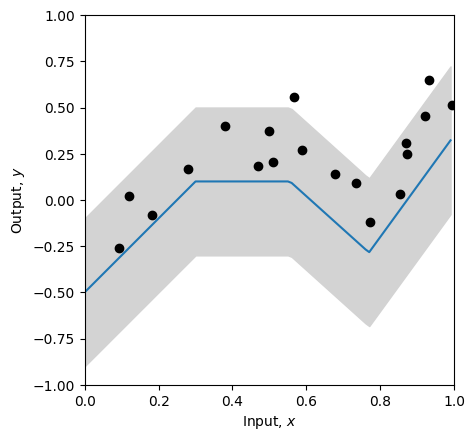

In [91]:
# Let's create some 1D training data
x_train = np.array(
    [
        0.09291784,
        0.46809093,
        0.93089486,
        0.67612654,
        0.73441752,
        0.86847339,
        0.49873225,
        0.51083168,
        0.18343972,
        0.99380898,
        0.27840809,
        0.38028817,
        0.12055708,
        0.56715537,
        0.92005746,
        0.77072270,
        0.85278176,
        0.05315950,
        0.87168699,
        0.58858043,
    ]
)
y_train = np.array(
    [
        -0.25934537,
        0.18195445,
        0.651270150,
        0.13921448,
        0.09366691,
        0.30567674,
        0.372291170,
        0.20716968,
        -0.08131792,
        0.51187806,
        0.16943738,
        0.3994327,
        0.019062570,
        0.55820410,
        0.452564960,
        -0.1183121,
        0.02957665,
        -1.24354444,
        0.248038840,
        0.26824970,
    ]
)

# Get parameters for the model
bias_0, weights_0, bias_1, weights_1 = get_parameters()
sigma = 0.2

# Define a range of input values
x_model = np.arange(0, 1, 0.01)
# Run the model to get values to plot and plot it.
y_model = shallow_nn(x_model, bias_0, weights_0, bias_1, weights_1)
plot_univariate_regression(x_model, y_model, x_train, y_train, sigma_model=sigma)

The blue line is the mean prediction of the model and the gray area represents plus/minus two standard deviations. This model fits okay, but could be improved. Let's compute the loss. We'll compute the the least squares error, the likelihood, the negative log likelihood.


In [63]:
# Return probability under normal distribution
def normal_distribution(y, mu, sigma):
    # Equation 5.7 from the notes (you will need np.sqrt() and np.exp(), and math.pi)
    # Don't use the numpy version -- that's cheating!
    # Replace the line below
    gaussian_factor = 1 / (sigma * np.sqrt(2 * math.pi))
    y_penalty = (y - mu) ** 2 / (2 * sigma**2)
    prob = gaussian_factor * np.exp(-y_penalty)
    return prob

## Equation 5.7

The probability density function (PDF) of a univariate normal (Gaussian) distribution. In mathematical terms, the PDF \( Pr(y|\mu, \sigma^2) \) for a Gaussian distribution is expressed as:

$
Pr(y|\mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(y - \mu)^2}{2\sigma^2}\right)
$

Where:

- $y$ is a variable representing the value at which the PDF is evaluated.
- $\mu $ is the mean of the distribution.
- $\sigma^2 $ is the variance of the distribution.
- $\exp $ denotes the exponential function.
- $\pi $ is the mathematical constant pi, approximately equal to 3.14159.
- $\sqrt{} $ denotes the square root.

This function gives the likelihood of different outcomes $ y $ under the Gaussian distribution defined by a particular mean $ \mu $ and variance $ \sigma^2 $. The exponential term $ -\frac{(y - \mu)^2}{2\sigma^2} $ penalizes deviations of $ y $ from the mean $ \mu $ based on the scale set by $ \sigma^2 $, with the overall scale of the PDF being normalized by the factor $ \frac{1}{\sqrt{2\pi\sigma^2}} $.

The second part of the text suggests that in a machine learning model, the mean $ \mu $ of the Gaussian distribution can be computed as a function of the input $ x $ and parameters $ \phi $: $ \mu = f(x, \phi) $. The model aims to predict the mean of the target distribution as its output.


In [33]:
# Let's double check we get the right answer before proceeding
print(
    "Correct answer = %3.3f, Your answer = %3.3f"
    % (0.119, normal_distribution(1, -1, 2.3))
)

Correct answer = 0.119, Your answer = 0.119


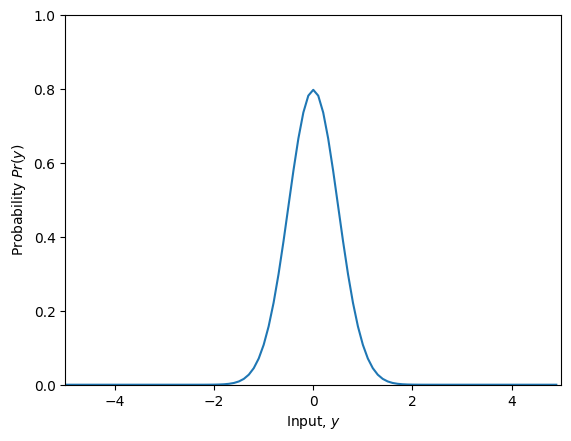

In [13]:
# Let's plot the Gaussian distribution.
y_gauss = np.arange(-5, 5, 0.1)
mu = 0
sigma = 0.5
gauss_prob = normal_distribution(y_gauss, mu, sigma)
fig, ax = plt.subplots()
ax.plot(y_gauss, gauss_prob)
ax.set_xlabel("Input, $y$")
ax.set_ylabel("Probability $Pr(y)$")
ax.set_xlim([-5, 5])
ax.set_ylim([0, 1.0])
plt.show()

# TODO
# 1. Predict what will happen if we change to mu=1 and leave sigma=1
# Now change the code above and see if you were correct.

# 2. Predict what will happen if we leave mu = 0 and change sigma to 2.0

# 3. Predict what will happen if we leave mu = 0 and change sigma to 0.5

Now let's compute the likelihood using this function


In [14]:
# Return the likelihood of all of the data under the model
def compute_likelihood(y_train, mu, sigma):
    # Top line of equation 5.3 in the notes
    # You will need np.prod() and the normal_distribution function you used above
    likelihood = np.prod(normal_distribution(y_train, mu, sigma))
    # This is the answer because we are multiplying the probabilities of each data point
    # under the normal distribution and we are assuming that the data points are independent
    # of each other.
    return likelihood

<img src="/Users/tobiahrex/code/me/learn_machine-learning/screenshots/Screenshot 2024-04-01 at 10.54.45 AM.png">


In [92]:
# Let's test this for a homoscedastic (constant sigma) model
# NOTE: "homoscedastic" means that the variance of the data is constant
bias_0, weight_0, bias_1, weight_1 = get_parameters()
# Use our neural network to predict the mean of the Gaussian
mean_pred = shallow_nn(x_train, bias_0, weight_0, bias_1, weight_1)
# Set the standard deviation to something reasonable
sigma = 0.2
# Compute the likelihood
likelihood = compute_likelihood(y_train, mean_pred, sigma)
# Let's double check we get the right answer before proceeding
print("Correct answer = %9.9f, Your answer = %9.9f" % (0.000010624, likelihood))

Correct answer = 0.000010624, Your answer = 0.000010624


You can see that this gives a very small answer, even for this small 1D dataset, and with the model fitting quite well. This is because it is the product of several probabilities, which are all quite small themselves.
This will get out of hand pretty quickly with real datasets -- the likelihood will get so small that we can't represent it with normal finite-precision math

This is why we use negative log likelihood


In [93]:
# Return the negative log likelihood of the data under the model
def compute_negative_log_likelihood(y_train, mu, sigma):
    # In other words, compute minus one times the sum of the log probabilities
    # Equation 5.4 in the notes
    # You will need np.sum(), np.log()
    # Replace the line below
    nll = -1 * np.sum(np.log(normal_distribution(y_train, mu, sigma)))

    return nll

<img src="/Users/tobiahrex/code/me/learn_machine-learning/screenshots/Screenshot 2024-04-01 at 10.59.32 AM.png">


In [95]:
# Let's test this for a homoscedastic (constant sigma) model
bias_0, weights_0, bias_1, weights_1 = get_parameters()
# Use our neural network to predict the mean of the Gaussian
mean_pred = shallow_nn(x_train, bias_0, weights_0, bias_1, weights_1)
# Set the standard deviation to something reasonable
print('mean_pred: ', mean_pred)
sigma = 0.2
# Compute the negative log likelihood
nll = compute_negative_log_likelihood(y_train, mean_pred, sigma)
# Let's double check we get the right answer before proceeding
print("Correct answer = %9.9f, Your answer = %9.9f" % (11.452419564, nll))

mean_pred:  [[-0.31416432  0.1         0.15996086 -0.11702777 -0.22195154 -0.01169818
   0.1         0.1        -0.13312056  0.33297469  0.05681618  0.1
  -0.25888584  0.07912033  0.13015802 -0.28051258 -0.05485016 -0.393681
  -0.00286078  0.04055523]]
Correct answer = 11.452419564, Your answer = 11.452419564


For good measure, let's compute the sum of squares as well


In [96]:
# Return the squared distance between the observed data (y_train) and the prediction of the model (y_pred)
def compute_sum_of_squares(y_train, y_pred):
    # TODO -- compute the sum of squared distances between the training data and the model prediction
    # Eqn 5.10 in the notes.  Make sure that you understand this, and ask questions if you don't
    # Replace the line below
    # sum_of_squares = 0;
    sum_of_squares = np.sum((y_train - y_pred) ** 2)

    return sum_of_squares

<img src="/Users/tobiahrex/code/me/learn_machine-learning/screenshots/Screenshot 2024-04-01 at 11.01.24 AM.png">

In [97]:
# Let's test this again
bias_0, weights_0, bias_1, weights_1 = get_parameters()
# Use our neural network to predict the mean of the Gaussian, which is out best prediction of y
y_pred = mu_pred = shallow_nn(x_train, bias_0, weights_0, bias_1, weights_1)
# Compute the sum of squares
sum_of_squares = compute_sum_of_squares(y_train, y_pred)
# Let's double check we get the right answer before proceeding
print("Correct answer = %9.9f, Your answer = %9.9f" % (2.020992572, sum_of_squares))

Correct answer = 2.020992572, Your answer = 2.020992572


Now let's investigate finding the maximum likelihood / minimum negative log likelihood / least squares solution. For simplicity, we'll assume that all the parameters are correct except one and look at how the likelihood, negative log likelihood, and sum of squares change as we manipulate the last parameter. We'll start with overall y offset, beta_1 (formerly phi_0)


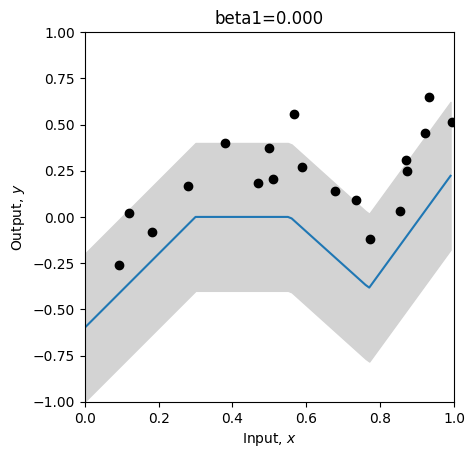

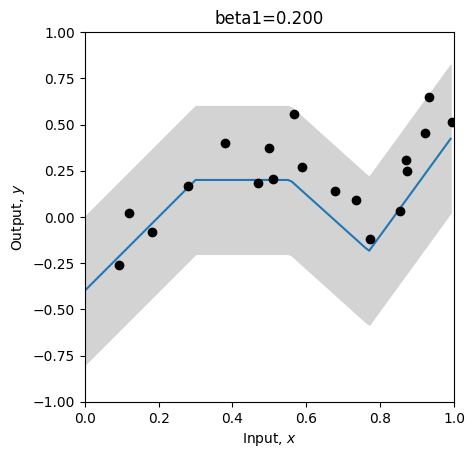

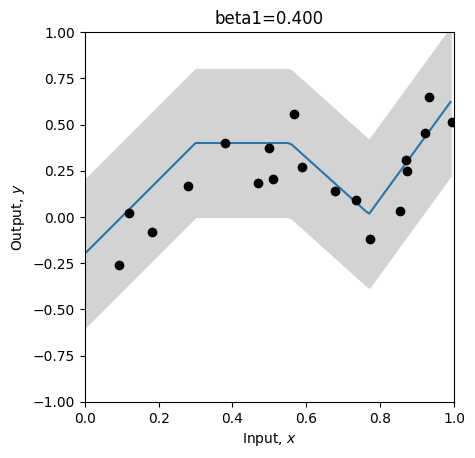

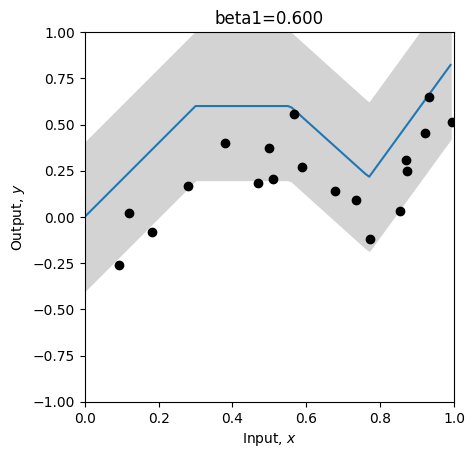

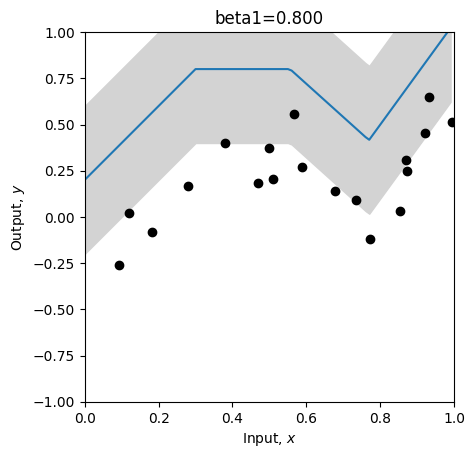

In [110]:
# Define a range of values for the parameter
bias_1_vals = np.arange(0, 1.0, 0.01)
# Create some arrays to store the likelihoods, negative log likelihoods and sum of squares
likelihoods = np.zeros_like(bias_1_vals)
nlls = np.zeros_like(bias_1_vals)
sum_squares = np.zeros_like(bias_1_vals)

# Initialise the parameters
bias_0, weights_0, bias_1, weights_1 = get_parameters()
sigma = 0.2
for i in range(len(bias_1_vals)):
    # Set the value for the parameter
    bias_1[0, 0] = bias_1_vals[i]
    # Run the network with new parameters
    y_pred = shallow_nn(x_train, bias_0, weights_0, bias_1, weights_1)
    # Compute and store the three values
    likelihoods[i] = compute_likelihood(y_train, y_pred, sigma)
    nlls[i] = compute_negative_log_likelihood(y_train, y_pred, sigma)
    sum_squares[i] = compute_sum_of_squares(y_train, y_pred)
    # Draw the model for every 20th parameter setting
    if i % 20 == 0:
        # Run the model to get values to plot and plot it.
        y_model = shallow_nn(x_model, bias_0, weights_0, bias_1, weights_1)
        plot_univariate_regression(
            x_model,
            y_model,
            x_train,
            y_train,
            sigma_model=sigma,
            title="beta1=%3.3f" % (bias_1[0, 0]),
        )

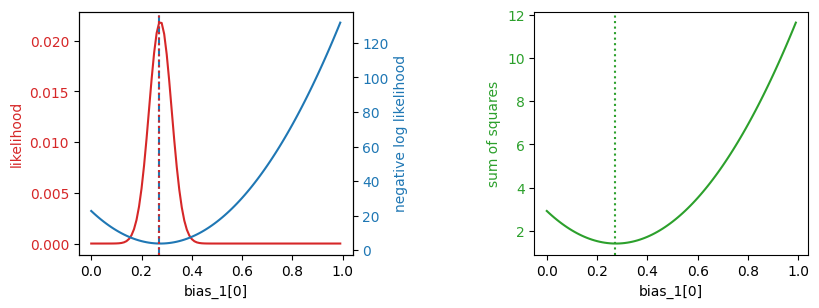

In [111]:
# Now let's plot the likelihood, negative log likelihood, and least squares as a function of the value of the offset beta1
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10.5, 5.5)
fig.tight_layout(pad=10.0)
likelihood_color = "tab:red"
nll_color = "tab:blue"

# Chart 1: Left Y-axis
ax[0].set_xlabel("bias_1[0]")
ax[0].set_ylabel("likelihood", color=likelihood_color)
ax[0].plot(bias_1_vals, likelihoods, color=likelihood_color)
ax[0].tick_params(axis="y", labelcolor=likelihood_color)

# Chart 2: Right Y-axis
ax00 = ax[0].twinx()
ax00.plot(bias_1_vals, nlls, color=nll_color)
ax00.set_ylabel("negative log likelihood", color=nll_color)
ax00.tick_params(axis="y", labelcolor=nll_color)

# Draw vertical line at the maximum likelihood
plt.axvline(x=bias_1_vals[np.argmin(nlls)], linestyle="dashed", color=nll_color)
plt.axvline(x=bias_1_vals[np.argmax(likelihoods)], linestyle="dotted", color=likelihood_color)

# Chart 3: Sum of squares
ax[1].plot(bias_1_vals, sum_squares, color="tab:green")
ax[1].tick_params(axis="y", labelcolor="tab:green")
ax[1].set_ylabel("sum of squares", color="tab:green")
ax[1].set_xlabel("bias_1[0]")
ax[1].axvline(x=bias_1_vals[np.argmin(sum_squares)], linestyle="dotted", color="tab:green")
plt.show()

Maximum likelihood = 0.022, at beta_1=0.270
Minimum negative log likelihood = 3.826, at beta_1=0.270
Least squares = 1.411, at beta_1=0.270


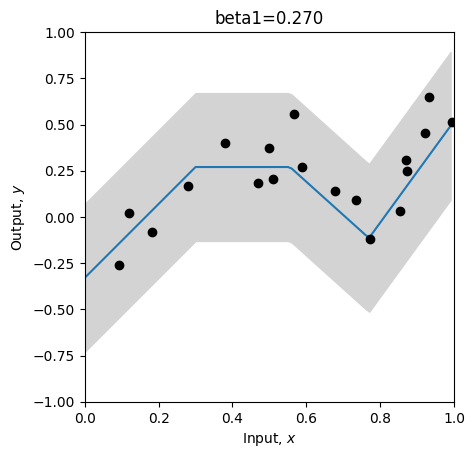

In [112]:
# Hopefully, you can see that the maximum of the likelihood fn is at the same position as the minimum negative log likelihood
# and the least squares solutions
# Let's check that:
liklihood_max_i = np.argmax(likelihoods)
print(
    "Maximum likelihood = %3.3f, at beta_1=%3.3f"
    % ((likelihoods[liklihood_max_i], bias_1_vals[liklihood_max_i]))
)
nll_min_i = np.argmin(nlls)
print(
    "Minimum negative log likelihood = %3.3f, at beta_1=%3.3f"
    % ((nlls[nll_min_i], bias_1_vals[nll_min_i]))
)
sqrs_min_i = np.argmin(sum_squares)
print(
    "Least squares = %3.3f, at beta_1=%3.3f"
    % (sum_squares[sqrs_min_i], bias_1_vals[sqrs_min_i])
)

# Plot the best model
bias_1[0, 0] = bias_1_vals[np.argmin(sum_squares)]
y_model = shallow_nn(x_model, bias_0, weights_0, bias_1, weights_1)
plot_univariate_regression(
    x_model,
    y_model,
    x_train,
    y_train,
    sigma_model=sigma,
    title="beta1=%3.3f" % (bias_1[0, 0]),
)

They all give the same answer. But you can see from the three plots above that the likelihood is very small unless the parameters are almost correct. So in practice, we would work with the negative log likelihood or the least squares.<br>

Let's do the same thing with the standard deviation parameter of our network. This is not an output of the network (unless we choose to make that the case), but it still affects the likelihood.


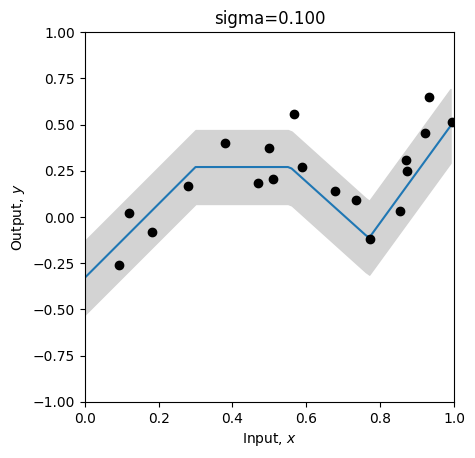

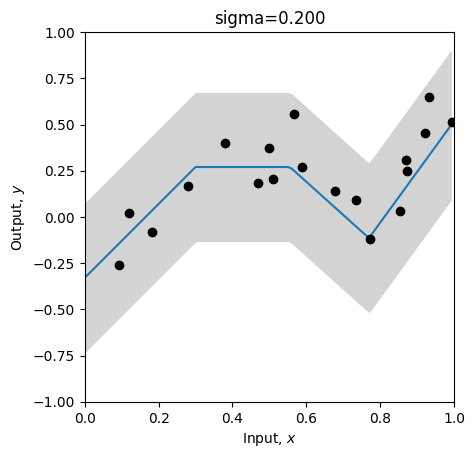

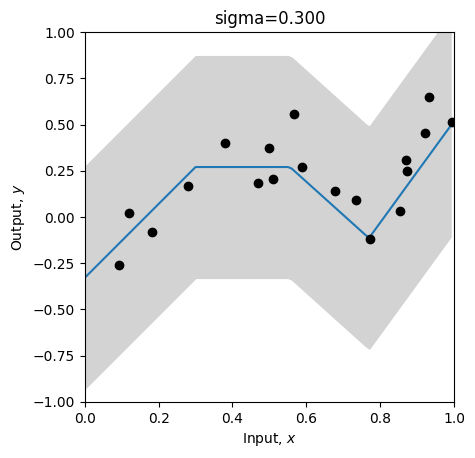

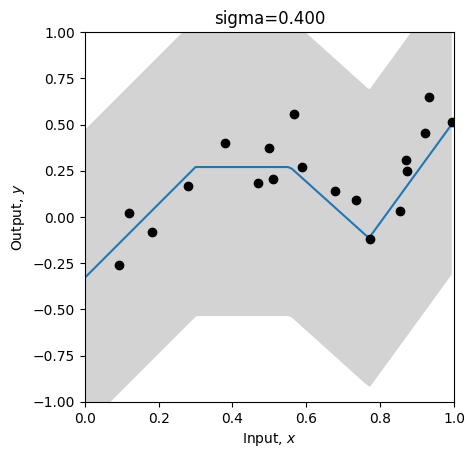

In [117]:
# Define a range of values for the parameter
sigma_vals = np.arange(0.1, 0.5, 0.005)
# Create some arrays to store the likelihoods, negative log likelihoods and sum of squares
likelihoods = np.zeros_like(sigma_vals)
nlls = np.zeros_like(sigma_vals)
sum_squares = np.zeros_like(sigma_vals)

# Initialise the parameters
bias_0, weights_0, bias_1, weights_1 = get_parameters()
# Might as well set to the best offset
bias_1[0, 0] = 0.27
for i in range(len(sigma_vals)):
    # Set the value for the parameter
    sigma = sigma_vals[i]
    # Run the network with new parameters
    y_pred = shallow_nn(x_train, bias_0, weights_0, bias_1, weights_1)
    # Compute and store the three values
    likelihoods[i] = compute_likelihood(y_train, y_pred, sigma)
    nlls[i] = compute_negative_log_likelihood(y_train, y_pred, sigma)
    sum_squares[i] = compute_sum_of_squares(y_train, y_pred)
    # Draw the model for every 20th parameter setting
    if i % 20 == 0:
        # Run the model to get values to plot and plot it.
        y_model = shallow_nn(x_model, bias_0, weights_0, bias_1, weights_1)
        plot_univariate_regression(
            x_model,
            y_model,
            x_train,
            y_train,
            sigma_model=sigma,
            title="sigma=%3.3f" % (sigma),
        )

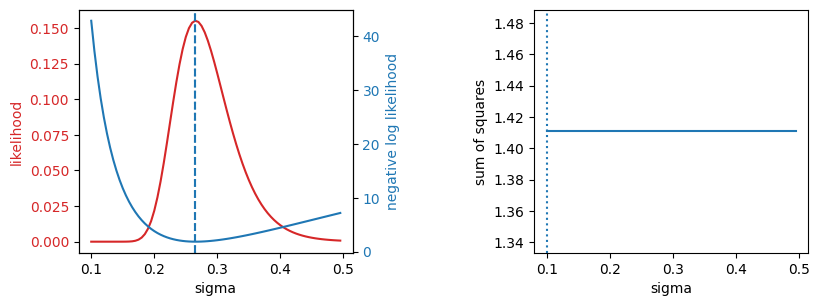

In [119]:
# Now let's plot the likelihood, negative log likelihood, and least squares as a function of the value of the standard deviation sigma
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10.5, 5.5)
fig.tight_layout(pad=10.0)
likelihood_color = "tab:red"
nll_color = "tab:blue"


ax[0].set_xlabel("sigma")
ax[0].set_ylabel("likelihood", color=likelihood_color)
ax[0].plot(sigma_vals, likelihoods, color=likelihood_color)
ax[0].tick_params(axis="y", labelcolor=likelihood_color)

ax00 = ax[0].twinx()
ax00.plot(sigma_vals, nlls, color=nll_color)
ax00.set_ylabel("negative log likelihood", color=nll_color)
ax00.tick_params(axis="y", labelcolor=nll_color)

ax[0].axvline(x=sigma_vals[np.argmax(likelihoods)], linestyle="dotted")
ax[0].axvline(x=sigma_vals[np.argmin(nlls)], linestyle="dashed")

ax[1].plot(sigma_vals, sum_squares)
ax[1].set_xlabel("sigma")
ax[1].set_ylabel("sum of squares")
ax[1].axvline(x=sigma_vals[np.argmin(sum_squares)], linestyle="dotted")
plt.show()

Maximum likelihood = 0.155, at sigma=0.265
Minimum negative log likelihood = 1.864, at sigma=0.265


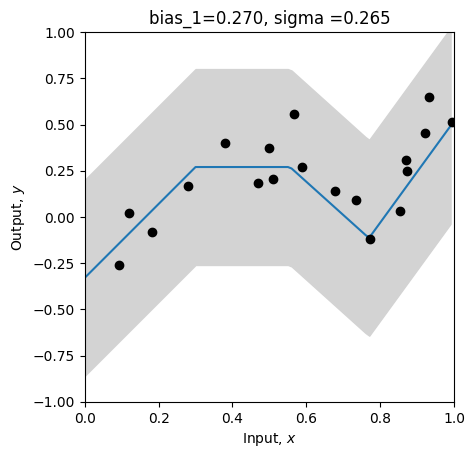

In [120]:
# Hopefully, you can see that the maximum of the likelihood fn is at the same position as the minimum negative log likelihood
# The least squares solution does not depend on sigma, so it's just flat -- no use here.
# Let's check that:
print(
    "Maximum likelihood = %3.3f, at sigma=%3.3f"
    % ((likelihoods[np.argmax(likelihoods)], sigma_vals[np.argmax(likelihoods)]))
)
print(
    "Minimum negative log likelihood = %3.3f, at sigma=%3.3f"
    % ((nlls[np.argmin(nlls)], sigma_vals[np.argmin(nlls)]))
)
# Plot the best model
sigma = sigma_vals[np.argmin(nlls)]
y_model = shallow_nn(x_model, bias_0, weights_0, bias_1, weights_1)
plot_univariate_regression(
    x_model,
    y_model,
    x_train,
    y_train,
    sigma_model=sigma,
    title="bias_1=%3.3f, sigma =%3.3f" % (bias_1[0, 0], sigma),
)

Obviously, to fit the full neural model we would vary all of the 10 parameters of the network in $\boldsymbol\beta_{0},\boldsymbol\Omega_{0},\boldsymbol\beta_{1},\boldsymbol\Omega_{1}$ (and maybe $\sigma$) until we find the combination that have the maximum likelihood / minimum negative log likelihood / least squares.<br><br>

Here we just varied one at a time as it is easier to see what is going on. This is known as **coordinate descent**.


## Hereoscedastic Regression
The previous models assumes that the variance of the data is constant everywhere. However, this might be unrealistic. When the uncertainty of the model varies as a function of the input data, we refer to this as heteroscedastic (as opposed to homoscedastic, where the uncertainty is constant).

A simple way to model this is to train a neural network f[x,ϕ] that computes both the mean and the variance. For example, consider a shallow network with **two outputs**. We denote the first output as f1[x,ϕ] and use this to predict the mean, and we denote the second output as f2[x,ϕ] and use it to predict the variance. There is one complication; the variance must be positive, but we can’t guarantee that the network will always produce a positive output. To ensure that the computed variance is positive, we pass the second network output through a function that maps an arbitrary value to a positive one. A suitable choice is the squaring function, giving:

$$
\mu = f_1[x, \phi] \\
\sigma^2 = f_2[x, \phi]^2,
$$

<br>

$$
\hat{\phi} = \argmin_{\phi} \left[ -\sum_{i=1}^{I} \left( \log \left( \frac{1}{\sqrt{2\pi f_2[x_i, \phi]}} \right) - \frac{(y_i - f_1[x_i, \phi])^2}{2f_2[x_i, \phi]^2} \right) \right].
$$

In [165]:
import numpy as np


# Define the Rectified Linear Unit (ReLU) function
def ReLU(preactivation):
    activation = preactivation.clip(0.0)
    return activation


# Define a shallow neural network with 2 layers for heteroscedastic regression.
def heteroscedastic_shallow_nn(
    x, bias_0, weights_0, bias_mu, weights_mu, bias_sigma, weights_sigma
):
    # Make sure that input data is (1 x n_data) array
    n_data = x.size
    x = np.reshape(x, (1, n_data))

    # This runs the network for ALL of the inputs
    bias_0_mat = bias_0.dot(np.ones((1, n_data)))
    weight_x_mat = np.matmul(weights_0, x)
    inactive_weights_bias = weight_x_mat + bias_0_mat
    hidden_layer = ReLU(inactive_weights_bias)

    # Predict the mean (mu) of the Gaussian distribution
    print('\n3 x 1 weights_mu: ', weights_mu)
    weight_mu_h1_mat = np.matmul(weights_mu, hidden_layer)
    print("\n3 x 1 weights_mu_h1: ", weight_mu_h1_mat)
    mu_bias = bias_mu.dot(np.ones((1, n_data)))
    print("\n3 x 1 bias_mu: ", mu_bias)
    mu = weight_mu_h1_mat + mu_bias
    print('mu: ', mu)

    # Predict the log variance (log_sigma) to ensure positive values
    # and then exponentiate to get the variance.
    bias_sigma_mat = bias_sigma.dot(np.ones((1, n_data)))
    weights_sigma_h1_mat = np.matmul(weights_sigma, hidden_layer)
    log_sigma = weights_sigma_h1_mat + bias_sigma_mat
    print("\n3 x 1 bias_sigma: ", bias_sigma_mat)
    print("\n 1 x 3 weights_sigma: ", weights_sigma)
    print("\n3 x 1 weights_sigma_h1: ", weights_sigma_h1_mat)
    print("\nlog_sigma: ", log_sigma)
    sigma = np.exp(log_sigma)
    print("\nsigma: ", sigma)

    return mu, sigma**2

mu_pred, sigma_pred = heteroscedastic_shallow_nn(x_train, bias_0, weights_0, bias_1, weights_1, bias_1, weights_1)
# np.matmul(weights_0, x_train)


3 x 1 weights_mu:  [[-2. -1.  7.]]

3 x 1 weights_mu_h1:  [[-0.41416432  0.          0.05996086 -0.21702777 -0.32195154 -0.11169818
   0.          0.         -0.23312056  0.23297469 -0.04318382  0.
  -0.35888584 -0.02087967  0.03015802 -0.38051258 -0.15485016 -0.493681
  -0.10286078 -0.05944477]]

3 x 1 bias_mu:  [[0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27
  0.27 0.27 0.27 0.27 0.27 0.27]]
mu:  [[-0.14416432  0.27        0.32996086  0.05297223 -0.05195154  0.15830182
   0.27        0.27        0.03687944  0.50297469  0.22681618  0.27
  -0.08888584  0.24912033  0.30015802 -0.11051258  0.11514984 -0.223681
   0.16713922  0.21055523]]

3 x 1 bias_sigma:  [[0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27
  0.27 0.27 0.27 0.27 0.27 0.27]]

 1 x 3 weights_sigma:  [[-2. -1.  7.]]

3 x 1 weights_sigma_h1:  [[-0.41416432  0.          0.05996086 -0.21702777 -0.32195154 -0.11169818
   0.          0.         -0.23312056  0.23297469 -0.04318382  0.

# Regarding the above code:
### Understanding Weights and Biases & their Dimensions
In the above code, we're passing several different weights. 
1. The first weight is applied to the input x. Then the bias is added to these weights, and finally they're passed thru the activation function.
   ```python
   # weights_0
   [[-1.  ]
   [ 1.8 ]
   [ 0.65]]

   # bias_0
   [[ 0.3]
   [-1. ]
   [-0.5]]

   # np.matmul(weights_0, x)
   [[-0.09291784 -0.46809093 -0.93089486 -0.67612654 -0.73441752 -0.86847339
   -0.49873225 -0.51083168 -0.18343972 -0.99380898 -0.27840809 -0.38028817
   -0.12055708 -0.56715537 -0.92005746 -0.7707227  -0.85278176 -0.0531595
   -0.87168699 -0.58858043]
   [ 0.16725211  0.84256367  1.67561075  1.21702777  1.32195154  1.5632521
      0.89771805  0.91949702  0.3301915   1.78885616  0.50113456  0.68451871
      0.21700274  1.02087967  1.65610343  1.38730086  1.53500717  0.0956871
      1.56903658  1.05944477]
   [ 0.0603966   0.3042591   0.60508166  0.43948225  0.47737139  0.5645077
      0.32417596  0.33204059  0.11923582  0.64597584  0.18096526  0.24718731
      0.0783621   0.36865099  0.59803735  0.50096975  0.55430814  0.03455367
      0.56659654  0.38257728]]

   # bias_0.dot(np.ones((1, x.shape[1])))
   [[ 0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3
      0.3  0.3  0.3  0.3  0.3  0.3]
   [-1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.  -1. ]
   [-0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
   -0.5 -0.5 -0.5 -0.5 -0.5 -0.5]]

   # bias + weights (Pre-Activation)
   [[ 0.20708216 -0.16809093 -0.63089486 -0.37612654 -0.43441752 -0.56847339
   -0.19873225 -0.21083168  0.11656028 -0.69380898  0.02159191 -0.08028817
      0.17944292 -0.26715537 -0.62005746 -0.4707227  -0.55278176  0.2468405
   -0.57168699 -0.28858043]
   [-0.83274789 -0.15743633  0.67561075  0.21702777  0.32195154  0.5632521
   -0.10228195 -0.08050298 -0.6698085   0.78885616 -0.49886544 -0.31548129
   -0.78299726  0.02087967  0.65610343  0.38730086  0.53500717 -0.9043129
      0.56903658  0.05944477]
   [-0.4396034  -0.1957409   0.10508166 -0.06051775 -0.02262861  0.0645077
   -0.17582404 -0.16795941 -0.38076418  0.14597584 -0.31903474 -0.25281269
   -0.4216379  -0.13134901  0.09803735  0.00096975  0.05430814 -0.46544632
      0.06659654 -0.11742272]]

   # Post-Activation: 3 x N results.
   [[0.20708216 0.         0.         0.         0.         0.
     1.         0.         0.11656028 0.         0.02159191 0.
     0.17944292 0.         0.         0.         0.         0.2468405
     2.         0.        ]
    [0.         0.         0.67561075 0.21702777 0.32195154 0.5632521
     3.         0.         0.         0.78885616 0.         0.
     4.         0.02087967 0.65610343 0.38730086 0.53500717 0.
     0.56903658 0.05944477]
    [0.         0.         0.10508166 0.         0.         0.0645077
     5.         0.         0.         0.14597584 0.         0.
     6.         0.         0.09803735 0.00096975 0.05430814 0.
     0.06659654 0.        ]]
   ```

2. The second weight is applied to the output of the first layer. Then a different **single** bias is added to these weights. The reason there's only one bias is because these second weight's and bias are applicable to all the Nueron's, not the inputs, whereas the first weight and bias are applied to the inputs. Also, this single bias is responsible for sliding the normal distribution to the left or right. Which leaves only one more parameter to be optimized, the variance (sigma).
   <img src="/Users/tobiahrex/code/me/learn_machine-learning/screenshots/Screenshot 2024-04-11 at 6.47.43 AM.png">
   ```python
   # Hidden-Layer to Output weights
   # 3 x 1 weights_mu:
   [[-2. -1.  7.]]

   # Bias shape
   # 1 x 1 bias_mu:
   [[0.27]]
   
   # Apply bias to all inputs
   # bias_mu.dot(np.ones((1, n_data))
   [[0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27]]
   
   # 1 x N weights_mu_h1:
   [[-0.41416432  0.          0.05996086 -0.21702777 -0.32195154 -0.11169818
      0.          0.         -0.23312056  0.23297469 -0.04318382  0.
   -0.35888584 -0.02087967  0.03015802 -0.38051258 -0.15485016 -0.493681
   -0.10286078 -0.05944477]]
   ```